In [1]:
import midynet, graphinf
import matplotlib.pyplot as plt
import numpy as np
import time

In [58]:
g0 = midynet.utility.convert.load_graph("../../midynet/config/littlerock.npy")
avgk = 2 * g0.get_total_edge_number() / g0.get_size()
g = graphinf.graph.ConfigurationModel(g0)
x = graphinf.data.dynamics.GlauberDynamics(g, length=1000, coupling=0.7 / avgk)
x.freeze_param()
x.freeze_graph_prior()
x.graph_prior.set_state(g0)
x.graph_prior.sample_state()
x.sample_state()

In [59]:
collector = graphinf.utility.EdgeCollector()
gg = x.get_graph()
collector.update(gg)
x.sample_prior()

for i in range(1000):
    t0 = time.time()
    x.metropolis_sweep(183 * 10)
    t1 = time.time()
    collector.update(x.get_graph())
    if i % 50 == 0:
        print(
            f"Epoch {i}: "
            f"time={t1 - t0:0.4f} "
            f"log(likelihood)={x.get_log_likelihood():0.4f} "
            f"log(prior)={x.get_log_prior():0.4f} "
        )
x.set_graph(gg)
print(x.get_log_prior(), collector.log_prob_estimate(gg))

Epoch 0: time=0.8303 log(likelihood)=-120123.9366 log(prior)=-5570.6027 
Epoch 50: time=0.7207 log(likelihood)=-118707.4520 log(prior)=-5649.5716 
Epoch 100: time=0.7240 log(likelihood)=-118745.9961 log(prior)=-5618.7832 
Epoch 150: time=0.7272 log(likelihood)=-118744.9850 log(prior)=-5642.8746 
Epoch 200: time=0.7197 log(likelihood)=-118684.3198 log(prior)=-5622.0801 
Epoch 250: time=0.7138 log(likelihood)=-118664.2235 log(prior)=-5623.2196 
Epoch 300: time=0.7195 log(likelihood)=-118714.9118 log(prior)=-5621.5580 
Epoch 350: time=0.7270 log(likelihood)=-118746.4960 log(prior)=-5622.1855 
Epoch 400: time=0.7195 log(likelihood)=-118696.3241 log(prior)=-5634.5568 
Epoch 450: time=0.7141 log(likelihood)=-118787.1992 log(prior)=-5629.9812 
Epoch 500: time=0.7227 log(likelihood)=-118737.2780 log(prior)=-5622.0156 
Epoch 550: time=0.7207 log(likelihood)=-118772.6919 log(prior)=-5621.3338 
Epoch 600: time=0.7249 log(likelihood)=-118703.6284 log(prior)=-5636.3248 
Epoch 650: time=0.7313 log(l

In [54]:
print(x.get_coupling(), x.get_log_prior(), collector.log_prob_estimate(gg))

0.036688052117824554 -5615.5825424012 -5406.154967448586


In [128]:
import tqdm.notebook as tqdm
from collections import defaultdict

In [162]:
J = np.linspace(0, 4, 50)
N, M = 5, 5
g_samples = 100
x_samples = 1000

g = graphinf.graph.ErdosRenyiModel(N, M)
S = []
for _J in J:
    x = graphinf.data.dynamics.GlauberDynamics(g, coupling=_J, length=2)
    
    X = np.zeros((g_samples, x_samples, g.get_size(), x.get_length()))

    for i in range(g_samples):
        x.sample_prior()
        for j in range(x_samples):
            x.sample_state(1)
            X[i, j] = np.array(x.get_past_states())
    Y_X = np.array([X[i].mean(0) for i in range(g_samples)])
    var_Y_X = np.var(Y_X, axis=0)
    var_Y = np.var(X, axis=(0, 1))
    S.append(var_Y_X.sum() / var_Y.sum())
    print(S[-1])
    
    


0.0010228033840350874
0.002559535351072795
0.007009441737935607
0.013213834328669656
0.016371883522781117
0.025037716491130957
0.02716826811338527
0.030657125599270404
0.031241007163451188
0.034704013419580446
0.0381905812147857
0.04041961355956329
0.04095303033613786
0.041916186035371006
0.04338965090677342
0.045654269485431546
0.048142797484787024
0.04877099354898373
0.04863811275321194
0.04849178102225901
0.04993020088095437
0.049783375779471686
0.05173805192412086
0.05634838828049302
0.05368416480416926
0.054094625047023864
0.05363604905536658
0.056424116587963105
0.052986039583043966
0.05072847119766372
0.05785183667541516
0.0540248037342843
0.05583034589165604
0.05122312791351534
0.05215297671622389
0.051125944379937414
0.04772495408924539
0.05302222684190991
0.05362632277094555
0.05261706998374779
0.05566074782513079
0.05171501683591614
0.050824018933539376
0.052331375491605825
0.05095784657741081
0.05472685572454951
0.05787225576482112
0.053772654516332855
0.05453187841451658
0

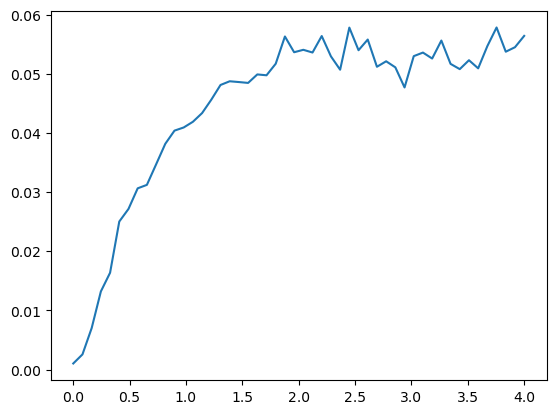

In [163]:
plt.plot(J, S)


In [155]:
g = graphinf.graph.ErdosRenyiModel(N, M)


n_samples = 20
n_sweeps = 500
J = np.linspace(0, 4, 10) / 5.
mi = []
hx = []
pred = []
for _J in J:
    x = graphinf.data.dynamics.GlauberDynamics(g, coupling=_J, length=10)
    data = defaultdict(list)
    for _ in tqdm.tqdm(range(n_samples), desc=f"J={_J}"):
        x.sample(int(N * 0.1))
        data["hg"].append(-x.get_log_prior())
        data["hxg"].append(-x.get_log_likelihood())
        og = x.get_graph()
        
        data["hgx"].append(-collector.log_prob_estimate(og))
        data["hx"].append(data["hg"][-1] + data["hxg"][-1] - data["hgx"][-1])
    data = {k: np.array(v) for k, v in data.items()}
    mi.append(np.mean(data["hg"] - data["hgx"]))
    hx.append(np.mean(data["hx"]))
    pred.append(mi[-1] / hx[-1])
    print(mi[-1], hx[-1], pred[-1])


J=0.0:   0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [1]:
import midynet, graphinf, matplotlib.pyplot as plt, numpy as np, pandas as pd, seaborn as sns

from scipy.linalg import det
from tqdm import notebook as tqdm
from collections import defaultdict

In [19]:
N, M = 100, 250

sobol = []
J = np.linspace(0, 4, 20)
g = graphinf.graph.ErdosRenyiModel(N, M, with_self_loops=False, with_parallel_edges=False)

for _J in tqdm.tqdm(J):
    x = graphinf.data.dynamics.GlauberDynamics(g, coupling=_J, length=50)

    n_samples = 20
    samples_v0 = []
    samples_v1 = []
    for _ in range(n_samples):
        x.sample_prior()
        s = []
        x.sample_state(1)
        x0 = x.get_state()
        for _ in  range(100):
            x.sample_state(x0)
            s.append(x.get_log_likelihood())
            samples_v1.append(x.get_log_likelihood())
        samples_v0.append(np.var(s))
        
    v0 = np.mean(samples_v0)
    v1 = np.var(samples_v1)
    sobol.append((v1 - v0)/v1)
    print(_J, sobol[-1])


  0%|          | 0/20 [00:00<?, ?it/s]

0.0 -0.7777777777777778
0.21052631578947367 0.09810713918156268
0.42105263157894735 0.2932098952546853
0.631578947368421 0.5769900788909644
0.8421052631578947 0.8425207584410466
1.0526315789473684 0.8249728516290957
1.263157894736842 0.8558970350244874
1.4736842105263157 0.8936022917821046
1.6842105263157894 0.8857820983821101
1.894736842105263 0.8961242519113013
2.1052631578947367 0.9461013710091961
2.3157894736842106 0.911009046472751
2.526315789473684 0.9514568152903421
2.7368421052631575 0.975378393036187
2.9473684210526314 0.9768047313109338
3.1578947368421053 0.9927665752507626
3.3684210526315788 0.9824025917579998
3.578947368421052 0.9952803050031767
3.789473684210526 0.9890544038291201
4.0 0.9961476450480308


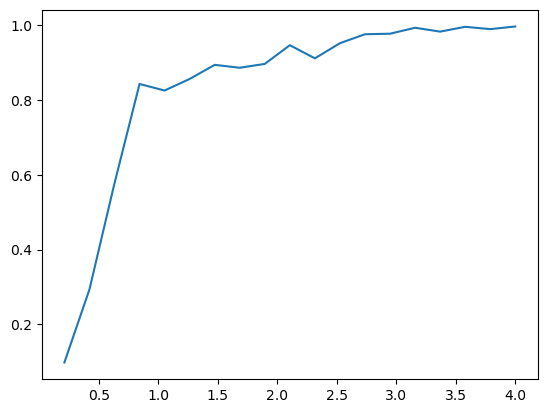

In [21]:
plt.plot(J[1:], sobol[1:])

In [25]:
data = defaultdict(list)

for _J in tqdm.tqdm(J[::2]):
    x = graphinf.data.dynamics.GlauberDynamics(g, coupling=_J, length=10)
    x0 = x.get_state()
    for _ in range(20):
        x.sample(x0)
        data["hg"].append(x.get_log_prior())
        data["hxg"].append(x.get_log_likelihood())
        data["hgx"].append(x.get_log_posterior(method="meanfield", n_sweeps=1000, n_steps_per_vertex=5))
        data["hx"].append(data["hg"][-1] + data["hxg"][-1] - data["hgx"][-1])
        data["J"].append(_J)
    print(_J, data["hgx"][-1] - data["hg"][-1])
    
df = pd.DataFrame(data)
df["pred"] = 1 - df["hxg"] / df["hx"]
df["mi"] = df["hgx"] - df["hg"]
sns.lineplot(df, x="J", y="mi")
sns.lineplot(df, x="J", y="pred")


  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

<Axes: xlabel='J', ylabel='pred'>

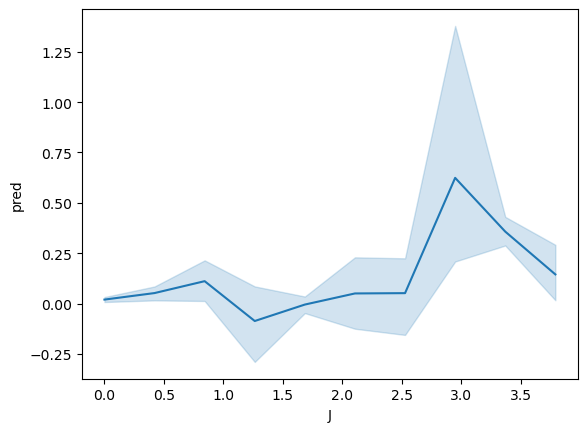

In [24]:
sns.lineplot(df, x="J", y="pred")

In [63]:
import midynet, graphinf, matplotlib.pyplot as plt, numpy as np, pandas as pd, seaborn as sns

from collections import defaultdict
from tqdm import notebook as tqdm

In [28]:
g0 = midynet.utility.convert.load_graph("../../midynet/config/littlerock.npy")

g = graphinf.graph.ConfigurationModel(g0)

  0%|          | 0/20 [00:00<?, ?it/s]

<Axes: xlabel='coupling', ylabel='X'>

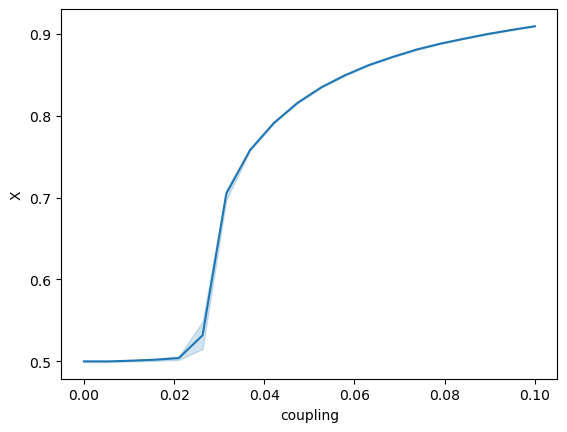

In [33]:
coup = np.linspace(0, 0.1, 20)
data = defaultdict(list)
n_samples = 50
for c in tqdm.tqdm(coup):
    x = graphinf.data.dynamics.GlauberDynamics(g, coupling=c, length=2*g.get_size())
    for _ in range(n_samples):
        x.sample(g.get_size())
        X = x.get_future_states()
        data["X"].append(np.mean(X))
        data["coupling"].append(c)
df = pd.DataFrame(data)
sns.lineplot(df, x="coupling", y="X")

In [52]:
data = defaultdict(list)
for c in tqdm.tqdm(coup):
    x = graphinf.data.dynamics.GlauberDynamics(g, coupling=c, length=2*g.get_size())
    x.freeze_param()
    x.freeze_graph_prior()
    
    for _ in range(10):
        x.sample(g.get_size())
        data["hg"].append(x.get_log_prior())
        data["hxg"].append(x.get_log_likelihood())
        data["hgx"].append(x.get_log_posterior(method="meanfield", n_sweeps=1000, n_steps_per_vertex=2, verbose=False))
        data["hx"].append(data["hg"][-1] + data["hxg"][-1] - data["hgx"][-1])
        data["coupling"].append(c)

df = pd.DataFrame(data)
df["mi"] = df["hgx"] - df["hg"]
df["recon"] = df["mi"] /-df["hg"]
df["pred"] = df["mi"] /-df["hx"]
        
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
axx = ax.twinx()
sns.lineplot(df, x="coupling", y="recon", ax=ax, label="Recon.")
sns.lineplot(df, x="coupling", y="pred", ax=axx, label="Pred.")


  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

<Axes: xlabel='coupling', ylabel='recon'>

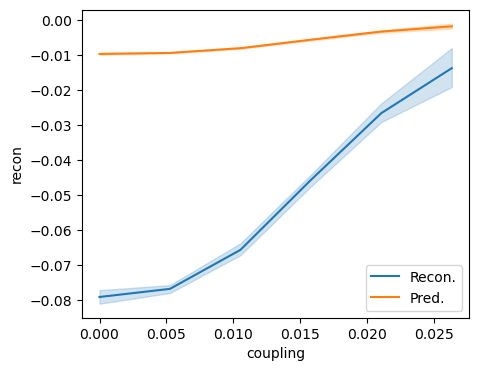

In [62]:
df = pd.DataFrame(data)
df["mi"] = df["hgx"] - df["hg"]
df["recon"] = df["mi"] /-df["hg"]
df["pred"] = df["mi"] /-df["hx"]
        
fig, ax = plt.subplots(1, 1, figsize=(5, 4))
# axx = ax.twinx()
sns.lineplot(df, x="coupling", y="recon", ax=ax, label="Recon.")
sns.lineplot(df, x="coupling", y="pred", ax=ax, label="Pred.")

In [ ]:
fig,
sns.lineplot()

In [7]:
g0 = midynet.config.GraphFactory.build(midynet.config.GraphConfig.euairlines())
g = graphinf.graph.ConfigurationModel(g0)

In [21]:
inf = np.linspace(0, 0.06, 20)
data = defaultdict(list)
n_samples = 50
for i in tqdm.tqdm(inf):
    
    x = graphinf.data.dynamics.SISDynamics(g, infection_prob=i, length=2*g.get_size())
    for _ in range(n_samples):
        x.sample(10)
        X = x.get_future_states()
        data["X"].append(np.mean(X))
        data["infection"].append(i)
df = pd.DataFrame(data)
sns.lineplot(df, x="infection", y="X")

  0%|          | 0/20 [00:00<?, ?it/s]

<Axes: xlabel='infection', ylabel='X'>

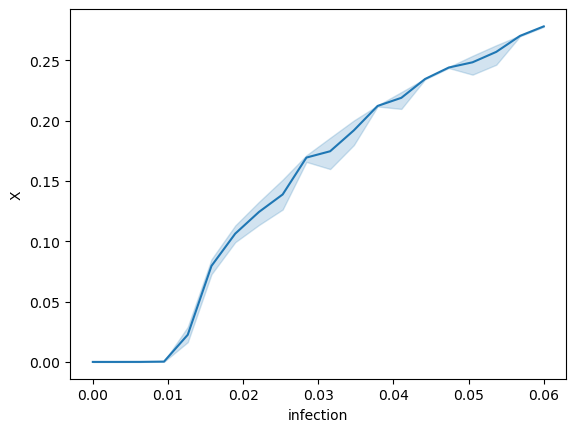

In [22]:
df = pd.DataFrame(data)
sns.lineplot(df, x="infection", y="X")

In [91]:
g0 = midynet.config.GraphFactory.build(midynet.config.GraphConfig.celegans())
g = graphinf.graph.ConfigurationModel(g0)


nu = np.append(np.linspace(0, 0.3, 20), np.linspace(0.05, 0.12, 20))
np.sort(nu)

data = defaultdict(list)
n_samples = 10
for _nu in tqdm.tqdm(nu):
    
    x = graphinf.data.dynamics.CowanDynamics(g, nu=_nu, a=8., eta=0.1, length=2 * g.get_size())
    for _ in range(n_samples):
        x.sample(5)
        X = np.array(x.get_past_states())

        x.sample(g.get_size() - 5)
        Y = np.array(x.get_past_states())
        data["forward"].append(np.mean(X))
        data["backward"].append(np.mean(Y))
        data["nu"].append(_nu)


    
    

  0%|          | 0/40 [00:00<?, ?it/s]

<Axes: xlabel='nu', ylabel='forward'>

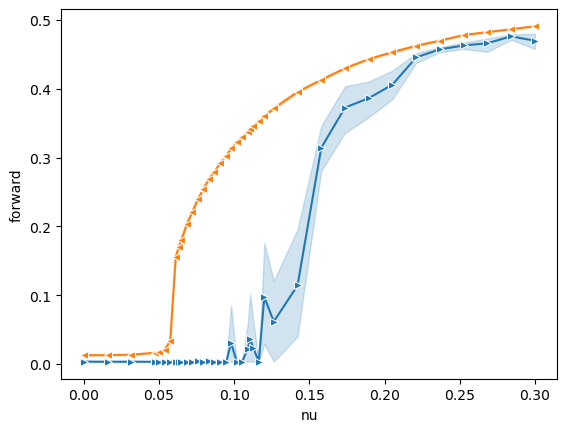

In [92]:
df = pd.DataFrame(data)
sns.lineplot(df, x="nu", y="forward", marker=">")
sns.lineplot(df, x="nu", y="backward", marker="<")


In [90]:
np.sort?